In [1]:
!pip -q install --upgrade together

In [2]:
import together
import os
from google.colab import userdata

os.environ["TOGETHER_API_KEY"] = userdata.get('TOGETHER_API_KEY')
# list available models and descriptons
models = together.Models.list()

<ipython-input-2-b00b997550e1>:9: DeprecationWarning: Call to deprecated function list.
  models = together.Models.list()


In [3]:
for model in models:
    if "Vision" in model['id'] :
        print(model['id'])
        print(model['pricing'])

meta-llama/Llama-Vision-Free
{'input': 0.0, 'output': 0.0, 'hourly': 0.0, 'base': 0.0, 'finetune': 0.0}
meta-llama/Llama-3.2-11B-Vision-Instruct-Turbo
{'input': 0.18000000000000002, 'output': 0.18000000000000002, 'hourly': 0.0, 'base': 0.0, 'finetune': 0.0}
meta-llama/Llama-Guard-3-11B-Vision-Turbo
{'input': 0.18000000000000002, 'output': 0.18000000000000002, 'hourly': 0.0, 'base': 0.0, 'finetune': 0.0}
meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo
{'input': 1.2, 'output': 1.2, 'hourly': 0.0, 'base': 0.0, 'finetune': 0.0}
SG161222/Realistic_Vision_V3.0_VAE
{'input': 0.0, 'output': 0.0, 'hourly': 0.0, 'base': 0.0, 'finetune': 0.0}


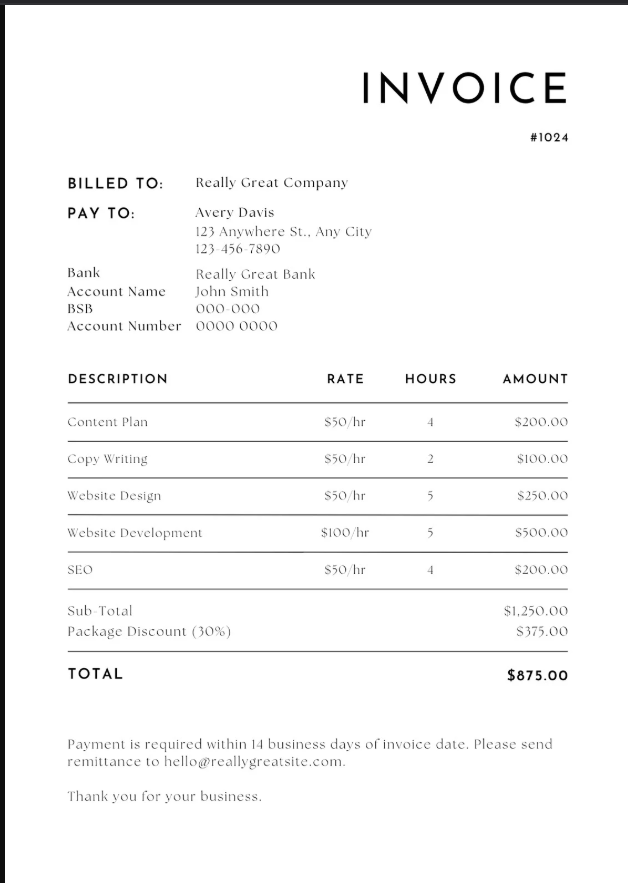

In [4]:
from PIL import Image
import requests
from io import BytesIO

img_path = "https://github.com/ManarM7md/Invoices/blob/main/Input/img.png?raw=true"

# Fetch the image from the URL
response = requests.get(img_path, stream=True)
response.raise_for_status()
# Open the image using BytesIO
image = Image.open(BytesIO(response.content)).convert("RGB")

image

In [5]:
import os
import base64
from typing import Optional, Literal
from together import Together

def encode_image(image_path: str) -> str:
    """Read and encode image to base64."""
    with open(image_path, 'rb') as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def is_remote_file(file_path: str) -> bool:
    """Check if the file path is a remote URL."""
    return file_path.startswith(('http://', 'https://'))

def get_markdown(
    together: Together,
    vision_llm: str,
    file_path: str
) -> str:
    """Process image and convert to markdown using Together AI."""
    system_prompt = """Convert the provided image into Markdown format. Ensure that all content from the page is included, such as headers, footers, subtexts, images (with alt text if possible), tables, and any other elements.
     Requirements:
    - Output Only Markdown: Return solely the Markdown content without any additional explanations or comments.
    - No Delimiters: Do not use code fences or delimiters like ```markdown.
    - Complete Content: Do not omit any part of the page, including headers, footers, and subtext.
    """

    final_image_url = file_path if is_remote_file(file_path) else f"data:image/jpeg;base64,{encode_image(file_path)}"

    output = together.chat.completions.create(
        model=vision_llm,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": system_prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": final_image_url
                        }
                    }
                ]
            }
        ]
    )

    return output.choices[0].message.content

def ocr(
    file_path: str,
    api_key: Optional[str] = None,
    model: Literal["Llama-3.2-90B-Vision", "Llama-3.2-11B-Vision", "free"] = "Llama-3.2-90B-Vision"
) -> str:
    """
    Perform OCR on an image using Together AI.

    Args:
        file_path: Path to the image file or URL
        api_key: Together AI API key (defaults to TOGETHER_API_KEY environment variable)
        model: Model to use for vision processing

    Returns:
        Markdown formatted text from the image
    """
    if api_key is None:
        api_key = os.getenv('TOGETHER_API_KEY')
        if api_key is None:
            raise ValueError("API key must be provided either directly or through TOGETHER_API_KEY environment variable")

    vision_llm = f"meta-llama/{model}-Instruct-Turbo" if model != "free" else "meta-llama/Llama-Vision-Free"

    together = Together(api_key=api_key)
    final_markdown = get_markdown(together, vision_llm, file_path)

    return final_markdown

In [11]:
from PIL import Image
from IPython.display import Markdown, display

output = ocr(
    "/content/img.png",
    api_key=os.getenv('TOGETHER_API_KEY'),
    model="Llama-3.2-11B-Vision"
)

display(Markdown(output))

# Invoice
# 1024

**Billed To:**
Really Great Company

**Pay To:**
Avery Davis
123 Anywhere St., Any City
123 456 7890

**Bank**
Really Great Bank
Account Name John Smith
BSB 000 000
Account Number 0000 0000

**DESCRIPTION** | **RATE** | **HOURS** | **AMOUNT**
----------------|--------|----------|---------
Content Plan    | $50/hr | 4        | $200.00
Copy Writing    | $50/hr | 2        | $100.00
Website Design  | $50/hr | 5        | $250.00
Website Development | $100/hr | 5        | $500.00
SEO            | $50/hr | 4        | $200.00

**Sub Total**    |        |          | $1,250.00
**Package Discount (30%)** |        |          | $375.00

**Total**        |        |          | $875.00

Payment is required within 14 business days of invoice date. Please send remittance to hello@reallygreatsite.com.

Thank you for your business.